In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os, sys, gc
import pickle

import itertools
import seaborn as sns

cmap1 = plt.get_cmap("tab20")
cmap2 = plt.get_cmap("tab20b")
cmap3 = plt.get_cmap("tab20c")
cmap4 = plt.get_cmap("Accent")
def colors():
    for c in np.concatenate((cmap1(np.arange(20)), cmap2(np.arange(20)), cmap3(np.arange(20)),cmap4(np.arange(8)))):
        yield c

os.chdir("/home/fvalle/phd/mouse_Atlas/")
sys.path.append("/home/fvalle/phd/")
sys.path.append("/home/fvalle/phd/master_thesis/")
from tableanalyser import discretize_df_columns, plotvarmen, plotcv2mean, plotoversigmacv2, getovergenes, plotoverpoints
from tacos_plot import scatterdense
#sns.set_context("paper")
#sns.set(font_scale=0.8, )

In [4]:
def get_files():
    # ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE108nnn/GSE108097/matrix/
    with open("mca/GSE108097-GPL17021_series_matrix.txt", "r") as file:
        os.chdir("data")
        for row in file.readlines():
            if "Sample_supplementary_file_1" in row:
                for sample in row.split("\t")[1:-1]:
                    print(sample)
                    os.system(f"wget {sample}")
    os.chdir("../")

In [5]:
#os.system('cd data && gunzip $(ls | grep -e "[a-zA-Z0-9\.\__].gz") && cd ..')
data_source ="tm"
files = os.listdir(data_source)
#rs = np.random.RandomState(seed=42)
#rs.shuffle(files)

In [13]:
def cleanup():
    os.chdir("data")
    for file in files:
        print(file)
        with open(file, "r") as f:
            data = f.read().replace("\"","")
        with open(file, "w") as f:
            f.write(data)
    os.chdir("../")
    
def load_pickle(filename):
    import pickle
    with open(filename,"rb") as f:
        data = pickle.load(f)
    return data
#cleanup()

In [ ]:
df_info = pd.read_csv("MCA_Figure2_Cell.info_V2.csv", index_col=0)
df_info['Cell_id'] = list(map(lambda ann: ann.replace("Adult",""), df_info['Cell_id'])) #remove adult or fetal
df_info['Cell_id'] = list(map(lambda ann: ann.replace("Fetal",""), df_info['Cell_id'])) #remove adult or fetal
df_info['tissue'] = list(map(lambda ann: ann.replace("Adult",""), df_info['tissue'])) #remove adult or fetal
df_info['tissue'] = list(map(lambda ann: ann.replace("Fetal",""), df_info['tissue'])) #remove adult or fetal
df_info['tissue'] = list(map(lambda ann: ann.replace("Neonatal",""), df_info['tissue'])) #remove adult or fetal
df_info.head()

In [ ]:
df_file=pd.read_csv("MCA_CellAssignments.csv", index_col=0).set_index('Cell.name')
df_file['Cell_type'] = list(map(lambda ann: ann.split('(')[0].split(' ')[0], df_file['Annotation'])) #remove adult or fetal
print(df_file.info())
print(df_file['Tissue'].unique())
print(df_file['Cell_type'].unique())
df_file.head()

In [ ]:
df_info = df_file
df_info["id"] = df_file.index.values
df_info.rename(columns={'Tissue':'tissue',"id": "Cell_id"}, inplace=True)
df_info.head()

In [14]:
def heaps(M, diffWords, tissue,  fit_bins = lambda x, a, b: a * np.power(x,b)):
    from scipy.optimize import curve_fit
    if len(M) < 2:
        return
    fig = plt.figure(figsize=(10,6))
    plt.title(tissue)
    plt.scatter(M, diffWords, label='samples')
    #plt.scatter(M_null, diffWords_null, label='null_model')
    plt.xlabel("Transcriptome size", fontsize=24)
    plt.ylabel("Number of\n expressed genes", fontsize=24)
    n_bins=35
    bin_means, bin_edges, binnumber = stats.binned_statistic(M, diffWords,statistic='mean', bins=np.linspace(M.min(),max(M), n_bins))
    bin_counts, _, _ = stats.binned_statistic(M, diffWords,statistic='count', bins=np.linspace(M.min(),max(M), n_bins))

    
    skip_bins=(bin_counts<10).astype(int).sum()
    x_bins = ((bin_edges[:-1]+bin_edges[1:])/2)[:-skip_bins]
    
    if len(bin_means) - skip_bins < 2:
        return

    plt.hlines(bin_means[:-skip_bins], bin_edges[:-1][:-skip_bins], bin_edges[1:][:-skip_bins], colors='r', lw=5, label='binned average')
    bin_stds, _, _ = stats.binned_statistic(M, diffWords,statistic='std',  bins=np.linspace(M.min(),max(M), n_bins))
    plt.errorbar(x_bins,bin_means[:-skip_bins], bin_stds[:-skip_bins], fmt='none', ecolor='orange', elinewidth=3)
    
    popt, pcov = curve_fit(fit_bins, x_bins, bin_means[:-skip_bins])

    plt.plot(np.linspace(500, 1e4), fit_bins(np.linspace(500, 1e4), *popt), lw=4, c='cyan')

    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.0E'))

    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlim(0,M.max()+500)
    plt.ylim(0,diffWords.max()+500)
    plt.legend(fontsize=20)
    plt.show()
    fig.savefig(f"heaps_{tissue}.png")
    

def save_model(df, name, tissue="global", n_bins=35, fit_bins = lambda x, a, b: a * np.power(x,b)):
    from scipy.optimize import curve_fit

    print("saving")
    from scipy.integrate import quad
    A = df.mean(axis=1)
    A = A[A>0]
    df = df.reindex(index=A.index)
    f = A/A.sum()
    O = df.apply(lambda x: len(x[x>0])/float(len(x)), 1)
    M = df.apply(np.sum, 0)
    diffWords = df.apply(lambda x: len(x[x>0]), 0)
    means = df.apply(np.mean, 1)
    var = df.apply(np.var, 1)
    cv2= var/means/means
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(M, diffWords,statistic='mean', bins=np.linspace(M.min(),max(M), n_bins))
    bin_counts, _, _ = stats.binned_statistic(M, diffWords,statistic='count', bins=np.linspace(M.min(),max(M), n_bins))
    
    skip_bins=(bin_counts<10).astype(int).sum()

    if len(bin_means) - skip_bins < 2:
        return
    
    x_bins = ((bin_edges[:-1]+bin_edges[1:])/2)[:-skip_bins]
    popt, pcov = curve_fit(fit_bins, x_bins, bin_means[:-skip_bins])
    
    data = {
    'means': means,
    'means_nonzero': df.apply(lambda x: x[x>0].mean(), 1),
    'var': var,
    'freq': f,
    'O': O,
    'M': M,
    'cv2': cv2,
    'diffWords': diffWords,
    'heaps_integral': quad(fit_bins, 500, 1e4, args=(popt[0], popt[1])),
    'heaps_fit': popt
    }

    with open(f"data_{tissue}_{name}.pkl","wb") as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)


def load_tissue(tissue, name="data", data_source="mca"):
    import pickle
    with open(f"{data_source}/data_{tissue}_{name}.pkl", "rb") as f:
        data = pickle.load(f)
    return data
        
        
def mazzolini(M, f, tissue):
    print("mazzolini")
    global rs 
    rs = np.random.RandomState(seed=42)
    df_null = pd.DataFrame(index=f.index)
    for sample in M.index:
        if sample in df_null.columns:
            continue
        df_null.insert(0,sample,np.average(np.array([rs.multinomial(M[sample], f.astype(float).values/f.sum()) for _ in range(5)]), axis=0))
        gc.collect()
    #df_null=df_null.astype(int)
    gc.collect()
    save_model(df_null, "mazzolini", tissue)
    del df_null
    gc.collect()
        
def null_model(df, M, means_nozero):
    print("null_model: start")
    global rs
    rs = np.random.RandomState(seed=42)
    f_null_1 = (means_nozero / means_nozero.sum()).dropna()
    df_null_1 = pd.DataFrame(index=f_null_1.index)
    number_of_zeros = df.apply(lambda x: len(x[x==0]), 1)
    for sample in M.index:
        if sample in df_null_1.columns:
            continue
        df_null_1.insert(0,sample,np.average(np.array([rs.multinomial(M[sample], f_null_1.astype(float).values) for _ in range(2)]), axis=0))
        gc.collect()
    df_null_1=df_null_1.round()
    #df_null_1 = df_null_1.divide(df_null_1.sum(0),1).multiply(M[df_null_1.columns])
    gc.collect()
    
    print("null model: flipping 0s")
    
    number_of_sampled_zeros = df_null_1.apply(lambda x: len(x[x==0]), 1)
    df_null_1 = df_null_1.transpose()

    quantiles = np.quantile(M.sort_values(), q=np.linspace(0,1,15)[:-1])
    classes = np.digitize(M.sort_values(),quantiles)

    genes_with_many_0 = []
    for g in df_null_1.columns:
        gexpr = df.loc[g,:]
        if number_of_zeros[g] > number_of_sampled_zeros[g]:
            df_null_1[g][rs.choice(df_null_1[g][df_null_1[g]>0].index, size=number_of_zeros[g]-number_of_sampled_zeros[g], replace=False)]=0
        else:
            genes_with_many_0.append(g)
        #df_null_1[g][rs.choice(df_null_1[g].index, size=number_of_zeros[g], replace=False)]=0
        #prob_classes = [(gexpr[M.index[classes==c]]==0).astype(int).sum()/float(len(M.index[classes==c])) for c in np.arange(max(classes))+1]
        #probs = pd.Series(index=M.index, data=np.zeros_like(M))
        #for c, prob_class in zip(classes, prob_classes):
        #    probs[M.index[classes==c]] = prob_class
        #df_null_1[g][rs.binomial(1,p=probs, size=len(df_null_1[g]))==1] = 0
        #del probs
        del gexpr
        gc.collect()
        
    df_null_1 = df_null_1.transpose()
    
    #df_null_1 = df_null_1.applymap(lambda x: 0 if rs.random()< np.exp(-x) else x)
    df_null_1 = df_null_1.divide(df_null_1.sum(0),1).multiply(M[~M.duplicated()][df_null_1.columns])
    gc.collect()
    save_model(df_null_1, "null_1", tissue)
    with open(f"many0genes_{tissue}.txt","w") as file:
        for g in genes_with_many_0:
            file.write(g+"\n")
    del df_null_1
    gc.collect()

In [ ]:
def clean_df(df):
    dfann = pd.read_csv("annotations_facs.csv")
    bad_cells = [c for c in df.columns if c not in dfann["cell"].values]
    df = df.drop(columns=bad_cells)
    genes_not_si=filter(lambda g: not 'ERCC' in g, df.index)
    df = df.reindex(index=list(genes_not_si))
    return df

In [ ]:
print(files[0])
#data = pd.read_csv(f"{data_source}/{files[0]}", sep=" ")
#data = data[data.columns[data.columns.isin(df_info['Cell_id'])]]

saved = []

#tissues = df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']=='Adult')]['tissue'].unique() # only adults
#tissues = df_info[df_info['Cell_id'].isin(data.columns)]['tissue'].unique()
tissues = [files[0]]
frac_of = {}


print(tissues)
for tissue in tissues:
    df = pd.read_csv(f"{data_source}/{files[0]}", sep=",", index_col=0)
    df = clean_df(df)
    #df = data.reindex(columns=df_info[df_info['Cell_id'].isin(data.columns) & (df_info['tissue']==tissue)]['Cell_id'])
    #df = df.divide(df.sum(0), 1).applymap(lambda cpm: np.log(cpm*1e6+1)) #log(cpm +1)
    A = df.sum(axis=1)
    O = df.apply(lambda x: len(x[x>0]), 1)
    M = df.apply(np.sum, 0)
    cell_zeros = df.astype(int).apply(lambda x: len(x[x==0]), 0)
    gene_presence = df.apply(lambda x: len(x[~x.isna()]), 1).astype(int)
    gene_presence_nonnull = df.apply(lambda x: len(x[~x.isna() & (x>0)]), 1).astype(int)
    var = df.apply(lambda x: (x*x).sum(), 1)
    
    frac_of[tissue] = {'data': A,
                            'N': len(M)}
    
    diffWords = df.apply(lambda x: len(x[x>0]), 0)
    n_genes = {}
    n_genes[tissue] = diffWords
    
    n_expressed_genes = pd.Series(index=df.index, data=np.zeros_like(df.index))
    n_expressed_genes[A.sort_values(ascending=False).index[:100]]+=1
    save_model(df, "data", tissue)
    #mazzolini(M, A/A.sum(), tissue)
    #null_model(df, M, A/gene_presence_nonnull)
    heaps(M, diffWords, tissue)
    
    saved.append(tissue)
    df.to_csv(f"mainTable_{tissue}.csv", index=True, header=True)

In [ ]:
for file in files[15:]:
    print(file)
    data = pd.read_csv(f"{data_source}/{file}", sep=",", index_col=0)
    #data = pd.read_csv(f"data/{file}", sep=" ")
    #data = data[data.columns[data.columns.isin(df_info['Cell_id'])]]
    
    #if len(data.columns) < 1:
    #    print(f"skipping {file} \n")
    #    continue
    
    #tissues = df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']=='Adult')]['tissue'].unique()
    #tissues = df_info[df_info['Cell_id'].isin(data.columns)]['tissue'].unique()

    tissues = [file]
    print(tissues)
    if len(tissues) < 1:
        print(f"no tissue found \n")
        continue
    for tissue in tissues:
        df = clean_df(data)
        
        #df = data.reindex(columns=df_info[df_info['Cell_id'].isin(data.columns) & (df_info['tissue']==tissue)]['Cell_id'])
        if tissue in saved:
            df = df.transpose().append(pd.read_csv(f"mainTable_{tissue}.csv", index_col=0, header=0).transpose(), ignore_index=False, sort=True).transpose().fillna(0)
        #df = df.divide(df.sum(0), 1).applymap(lambda cpm: np.log(cpm*1e6+1)) #log(cpm +1)
        A_sub = df.sum(axis=1)
        O_sub = df.apply(lambda x: len(x[x>0]), 1)
        M_sub = df.apply(np.sum, 0)
        cell_zeros_sub = df.apply(lambda x: len(x[x>0]), 0)
        diffWords_sub = df.apply(lambda x: len(x[x>0]), 0)
        
        if tissue in frac_of.keys():
            frac_of[tissue]['data'].add(A_sub, fill_value = 0)
            frac_of[tissue]['N']+=len(M_sub)
        else:
            frac_of[tissue] = {'data': A_sub,
                                  'N': len(M_sub)}

        A = A.add(A_sub, fill_value=0)
        O = O.add(O_sub, fill_value=0)
        M = M.append(M_sub)
        cell_zeros = cell_zeros.append(cell_zeros_sub)
        diffWords = diffWords.append(diffWords_sub)
        if tissue in n_genes.keys():
            n_genes[tissue] = n_genes[tissue].append(diffWords_sub)
        else:
            n_genes[tissue]= diffWords_sub
        
        gene_presence = gene_presence.add(df.apply(lambda x: len(x[~x.isna()]), 1), fill_value=0)
        gene_presence_nonnull_sub = df.apply(lambda x: len(x[~x.isna() & (x>0)]), 1).astype(int)
        gene_presence_nonnull = gene_presence_nonnull.add(gene_presence_nonnull_sub, fill_value=0).astype(int)
        var = var.add(df.apply(lambda x: (x*x).sum(), 1), fill_value=0)
        
        n_expressed_genes_sub = pd.Series(index=df.index, data=np.zeros_like(df.index))
        n_expressed_genes_sub[A_sub.sort_values(ascending=False).index[:100]]+=1
        n_expressed_genes = n_expressed_genes.add(n_expressed_genes_sub, fill_value=0)

        save_model(df,"data",tissue)
        #mazzolini(M_sub, A_sub/A_sub.sum(), tissue)
        #null_model(df, M_sub, A_sub/gene_presence_nonnull_sub)
        heaps(M_sub, diffWords_sub, tissue)
        saved.append(tissue)
        df.to_csv(f"mainTable_{tissue}.csv", index=True, header=True)
        print(f"Handling {len(M)} cells")

        del df 
        del A_sub
        del O_sub
        del M_sub
        del diffWords_sub
        del gene_presence_nonnull_sub
        gc.collect()
        print("\n")
    del tissues
    del data
    gc.collect()

means = A/gene_presence
means_nozero = A/gene_presence_nonnull
var = var/gene_presence - means*means
f = (A/A.sum())
O = O / gene_presence
O = O.reindex_like(means)
cv2 = var/means/means


print("Saving data.pkl")
data = {
    'means': means,
    'var': var,
    'freq': A/A.sum(),
    'O': O,
    'M': M,
    'cv2': cv2,
    'diffWords': diffWords,
    'means_nonzero': means_nozero,
    'n_expressed': n_expressed_genes,
    'n_genes': n_genes,
    'frac_of': frac_of,
    'cell_zeros': cell_zeros
}

with open("data_all.pkl","wb") as file:
    pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open(f"{data_source}/data_all.pkl","rb") as file:
    data = pickle.load(file)

means = data['means']
var = data['var']
f = data['freq']
O = data['O']
M = data["M"]
cv2 = data['cv2']
diffWords = data['diffWords']
means_nozero = data['means_nonzero']
n_expressed_genes = data['n_expressed']
n_genes = data['n_genes']
frac_of = data['frac_of']
cell_zeros = data['cell_zeros']

In [ ]:
#A = df.sum(axis=1)
#f = A/A.sum()
#O=O/len(M)
#O = df.apply(lambda x: len(x[x>0])/float(len(x)), 1)
#M = df.apply(np.sum, 0)
#diffWords = df.apply(lambda x: len(x[x!=0]), 0)
#means = df.apply(np.average, 1)
#var = df.apply(np.var, 1)
#cv2 = var/means/means

In [ ]:
with open("10_most_expressed_in_68_tissues.txt", "w") as f:
    list(map(lambda x: f.write(x+"\n"),n_expressed_genes[n_expressed_genes>=68].sort_values(ascending=False).index[:10]))

# Fraction of trascriptome

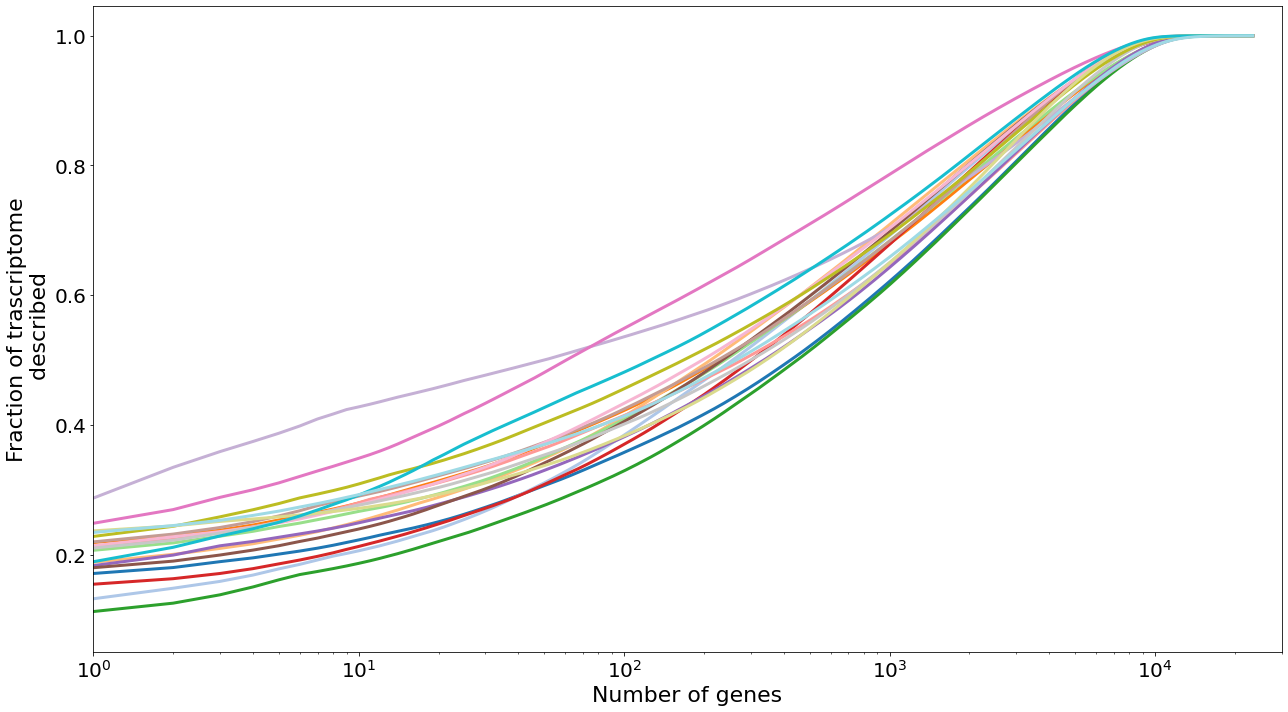

In [16]:
palette = colors()

thresholded = {}

fig,ax = plt.subplots(figsize=(18,10))
for tissue in frac_of.keys():
    A_tissue = (frac_of[tissue]['data'] / frac_of[tissue]['N']).sort_values(ascending=False)
    A_tissue_sum = np.cumsum(A_tissue.values) / A_tissue.sum() #h thr
    ax.plot(A_tissue_sum, label = tissue, c=next(palette))
    if len(A_tissue_sum) < 2:
        continue
    thresholded[tissue] = A_tissue_sum[99]
    #thresholded[tissue] = np.argwhere(A_tissue_sum>=0.4).ravel()[0] #v thr
ax.set_xscale('log')
ax.set_xlim(1, 3e4)
ax.tick_params(labelsize=20)
ax.set_xlabel("Number of genes", fontsize=22)
ax.set_ylabel("Fraction of trascriptome\n described", fontsize=22)

# Shrink current axis by 20%
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
fig.savefig("fracof_mca.pdf")

In [ ]:
gene_to_thr = pd.DataFrame(data= thresholded.items()).set_index(0).sort_values(1, ascending=False)

fig,ax = plt.subplots(figsize=(20,10))
ax.bar(gene_to_thr.index, gene_to_thr.values.ravel())
ax.tick_params(rotation=90)

ax.set_ylabel("Fraction of trascriptome\n described by 100 genes", fontsize=24)
#ax.set_ylabel("Number of genes\n to describe 40% of trascriptome", fontsize=24)

plt.tight_layout()
plt.show()
fig.savefig("frac_of_100genes.pdf")

In [ ]:
pd.DataFrame(index=gene_to_thr.sort_values(1).index, data=range(len(gene_to_thr)), columns=['MCA']).to_csv("trascriptome_sort.csv", index=True)

In [ ]:
df_sort = pd.read_csv("trascriptome_sort.csv", index_col=0).dropna(how='any', axis=0).astype(int)
df_sort['MCA'] = range(len(df_sort))
fig = plt.figure(figsize=(10,8))
plt.scatter(*df_sort.values.T, s=90)
plt.xlim(-1,15)
plt.ylim(-1,15)

plt.xlabel("MCA", fontsize=20)
plt.ylabel("tabula_muris", fontsize=20)
plt.show()

In [ ]:
for g in frac_of['MammaryGland.Lactation']['data'].sort_values(ascending=False).index[:10]:
    print(g)

## Box plot

In [ ]:
fig,ax=plt.subplots(figsize=(45,35))
organ_names=n_genes.keys()
n_genes_all=list(map(lambda organ: organ[1].values,n_genes.items()))
box1=plt.boxplot(np.array(n_genes_all), vert=True, patch_artist=True,notch=True,
        boxprops=dict(facecolor='magenta', color='magenta'))
ax.set_xticklabels(labels=organ_names,rotation=75)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=18)
plt.title('Number of genes detected per cell', fontsize=28)
plt.xlabel('Organ', fontsize=28)
plt.ylabel('N genes', fontsize=28)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()
fig.savefig("boxplot.pdf")

# All Tissues

## Zipf

<class 'FileNotFoundError'> [Errno 2] No such file or directory: 'tm/data__DS_Store_data.pkl' <traceback object at 0x7f7e2e95a7c8>


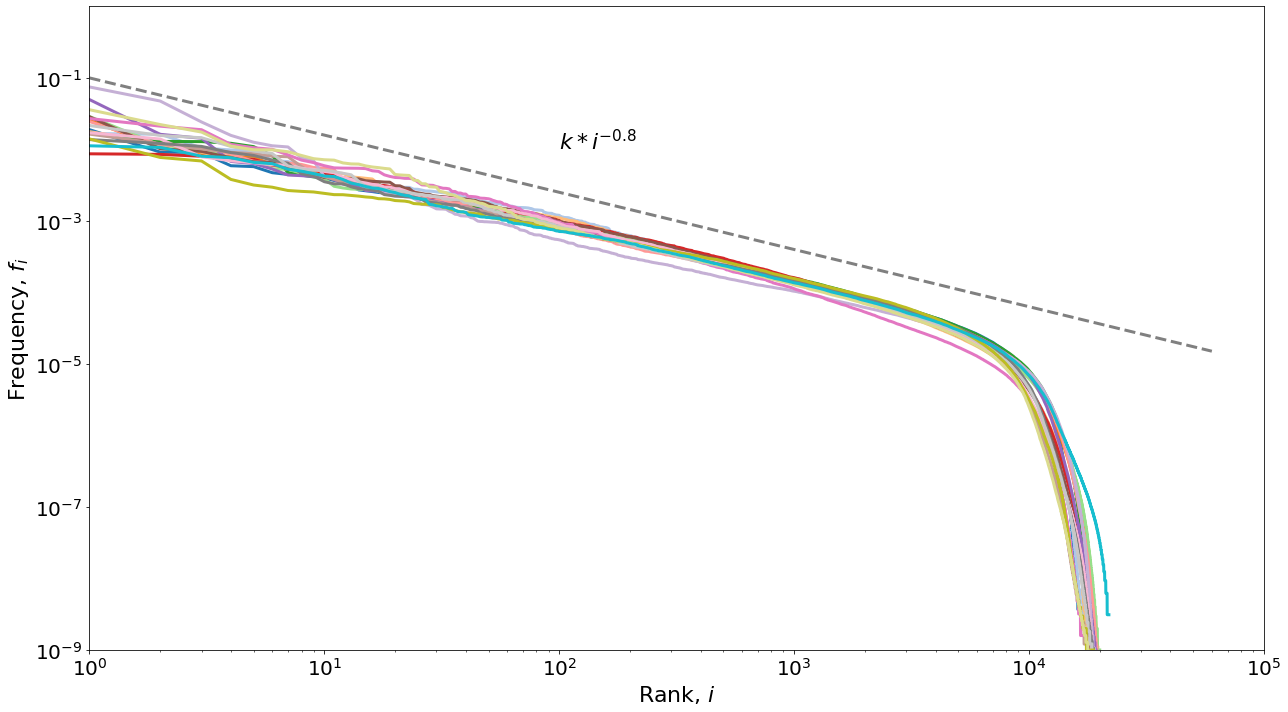

In [18]:
palette = colors()

fig, ax = plt.subplots(figsize=(18,10))
for tissue in data["frac_of"].keys():
    try:
        info = load_tissue(tissue, data_source=data_source)
    except:
        print(*sys.exc_info())
        continue    
    f = info["freq"]
    ax.plot(f.sort_values(ascending=False).values, label=tissue, c=next(palette))
    
x =np.linspace(1,6e4,10)

exp = 0.8
ax.plot(x, 1e-1*np.power(x, -0.8), lw=3, c='gray', ls='--')

ax.set_xscale("log")
ax.set_yscale("log")

ax.annotate('$k*i^{-%.1f}$'%exp, (1e2,1e-2), fontsize=22)

# Shrink current axis by 20%
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, ncol=2)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
ax.set_xlabel("Rank, $i$", fontsize=22)
ax.set_ylabel("Frequency, $f_i$", fontsize=22)

plt.show()
fig.savefig("zipf_alltissue_mca.pdf")

## Heaps

<class 'FileNotFoundError'> [Errno 2] No such file or directory: 'tm/data__DS_Store_data.pkl' <traceback object at 0x7f7e2e72fc48>


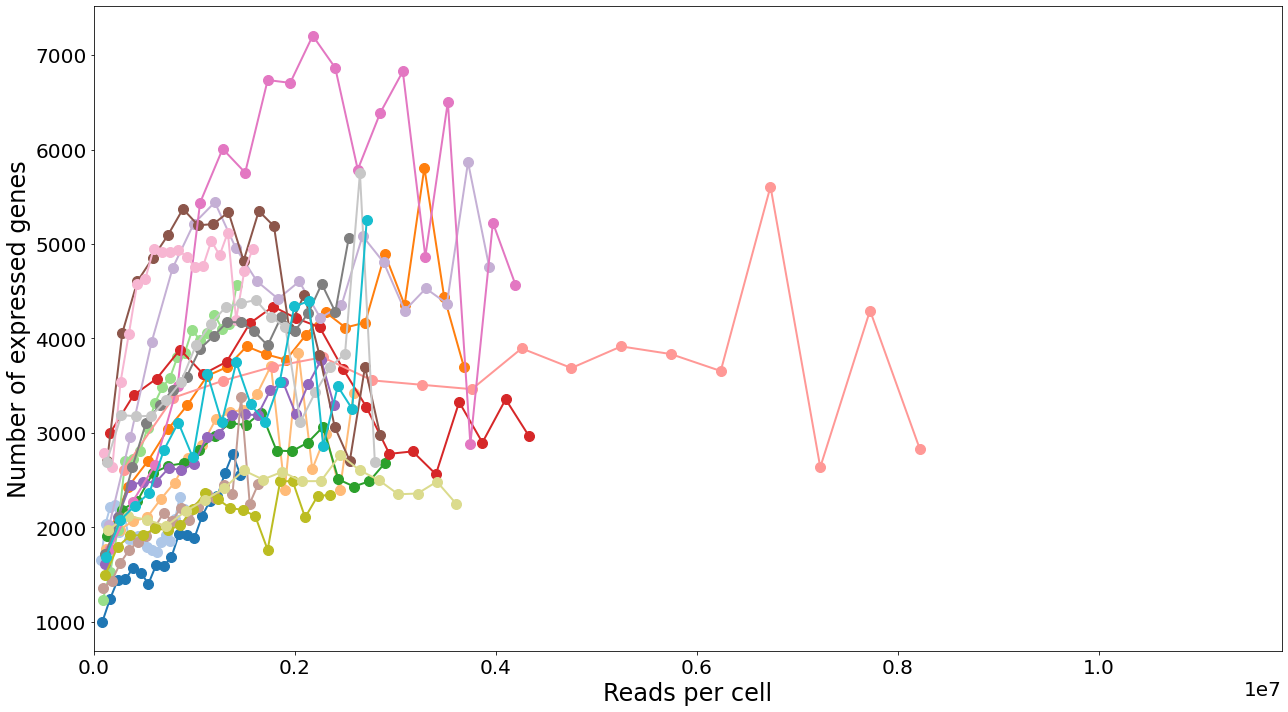

In [20]:
palette = colors()


fig, ax = plt.subplots(figsize=(18,10))
for tissue in data["frac_of"].keys():
    try:
        info = load_tissue(tissue, data_source=data_source)
    except:
        print(*sys.exc_info())
        continue
    M = info["M"]
    diff= info["diffWords"]
    skip_bins = 15
    n_bins=35
    if len(M) <= n_bins:
        continue
    bin_means, bin_edges, binnumber = stats.binned_statistic(M, diff,statistic='mean', bins=np.linspace(M.min(),max(M), n_bins))
    bin_stds, _, _ = stats.binned_statistic(M, diff,statistic='std', bins=np.linspace(M.min(),np.quantile(M, 0.9), n_bins))
    x = ((bin_edges[:-1]+bin_edges[1:])/2.)[:-skip_bins]
    y = bin_means[:-skip_bins]
    ax.plot(x, y, marker='o', lw=2, ms=10, c=next(palette), label=tissue)
    #ax.errorbar(x,y , bin_stds[:-skip_bins], fmt='none', ecolor='orange', elinewidth=3)

    
ax.set_xlabel("Reads per cell", fontsize=24)
ax.set_ylabel("Number of expressed genes", fontsize=24)

#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,max(data["M"])*0.7)
    
# Shrink current axis by 20%
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, ncol=2)

plt.show()
fig.savefig("heaps_alltissues.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
for tissue in data["frac_of"].keys():
    try:
        info = load_tissue(tissue)
    except:
        continue
    M = info["M"]
    diff= info["diffWords"]
    x = M
    y = diff
    ax.plot(x, y, marker='o', lw=0, ms=10, c=next(palette), alpha=0.6, label=tissue)
    #ax.errorbar(x,y , bin_stds[:-skip_bins], fmt='none', ecolor='orange', elinewidth=3)

    
ax.set_xlabel("Realization size", fontsize=24)
ax.set_ylabel("#different words", fontsize=24)

#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,max(data["M"])*0.7)
    
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, ncol=2)

plt.show()
fig.savefig("heaps_alltissues_alldata.pdf")

# Null Model

In [ ]:
with open("data_null.pkl","rb") as file:
    data = pickle.load(file)

means_null = data['means']
var_null = data['var']
f_null = data['freq']
O_null = data['O']
M_null=data["M"]
cv2_null = data['cv2']
diffWords_null = data['diffWords']

# Zipf

In [ ]:
fig = plt.figure(figsize=(15,8))
x = np.arange(1, len(f))
plt.ylabel("$Frequency, f_i$", fontsize=24)
plt.xlabel("$RANK, i$", fontsize=24)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-7,1)
plt.plot(x, np.power(x,-0.9)*1e-1, 'g--', lw=2, label='$k*i^{-0.5}$')
plt.plot(np.sort(f.dropna())[::-1], c='blue', lw=5, label='Genes')
if "f_null" in vars().keys():
    plt.plot(np.sort(f_null/f_null.sum())[::-1], c='orange', ls='--', lw=5, label='null_model')
plt.legend(fontsize=24)
plt.show()
fig.savefig("zipf.pdf")

In [ ]:
bins = 100
rang = (0-0.5/bins, 1+0.5/bins)
fig=plt.figure()
plt.hist(np.array(O.dropna(), dtype=float), histtype='step', lw=5, range = rang, color='blue', density=True, bins=bins)
if "O_null" in vars().keys():
    plt.hist(np.array(O_null, dtype=float), histtype='step', lw=5, range = rang, bins=bins, color='orange', ls='--', density=True)
plt.xlabel("$o_i$", fontsize=24)
plt.ylabel("pdf", fontsize=24)
#plt.yscale('log')
#plt.xscale('log')
plt.show()
fig.savefig("U.pdf")

In [ ]:
bins = 15
rang = (0-0.5/bins, 1+0.5/bins)
fig=plt.figure()
plt.hist(np.array(O.dropna(), dtype=float), histtype='step', lw=5, range = rang, color='blue', density=True, bins=bins)
if "O_null" in vars().keys():
    plt.hist(np.array(O_null, dtype=float), histtype='step', lw=5, range = rang, bins=bins, color='orange', ls='--', density=True)
plt.xlabel("$o_i$", fontsize=24)
plt.ylabel("pdf", fontsize=24)
plt.yscale('log')
#plt.xscale('log')
plt.show()
fig.savefig("U_log.pdf")

In [ ]:
fig, ax=plt.subplots()
O.hist(ax=ax, histtype='step', lw=5, color='blue', density=True)
#plt.hist(np.array(O_null, dtype=float), histtype='step', lw=5, range = rang, color='orange', ls='--', density=True)
plt.xlabel("$o_i$", fontsize=24)
plt.ylabel("pdf", fontsize=24)
#plt.yscale('log')
#plt.xscale('log')
plt.show()
fig.savefig("U_zoom.pdf")

In [ ]:
fig = plt.figure()
plt.hist(M, density=False, color='blue', bins = 15, label='files')
#plt.hist(M_null, density=False, color='orange', histtype='step', lw=4, ls='--', bins = 15, label='files')
plt.title("realization size distribution", fontsize = 24)
plt.xlabel("total counts per file", fontsize=24)
plt.ylabel("#", fontsize=24)
plt.legend(fontsize=24)
plt.show()
fig.savefig("M_distr.png")

In [ ]:
fig = plt.figure()
plt.hist(diffWords, density=False, color='blue', bins = 15, label = 'files')
plt.title("vocabulary size distribution", fontsize=18)
plt.xlabel("#different words per file", fontsize=16)
plt.ylabel("#", fontsize=16)
plt.legend(fontsize=18)
plt.show()
fig.savefig("gene_expr_distr.png")

## Heaps

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.scatter(data["M"], diffWords, label='samples')
if "M_null" in vars().keys() and "diffWords_null" in vars().keys():
    plt.scatter(M_null, diffWords_null, label='null_model')
plt.xlabel("Realization size", fontsize=24)
plt.ylabel("#different words", fontsize=24)
skip_bins = 15
n_bins=35
bin_means, bin_edges, binnumber = stats.binned_statistic(data["M"], diffWords,statistic='mean', bins=np.linspace(data["M"].min(),max(data["M"]), n_bins))
plt.hlines(bin_means[:-skip_bins], bin_edges[:-1][:-skip_bins], bin_edges[1:][:-skip_bins], colors='r', lw=5, label='binned average')
bin_stds, _, _ = stats.binned_statistic(data["M"], diffWords,statistic='std', bins=np.linspace(M.min(),np.quantile(M, 0.9), n_bins))
plt.errorbar(((bin_edges[:-1]+bin_edges[1:])/2)[:-skip_bins],bin_means[:-skip_bins], bin_stds[:-skip_bins], fmt='none', ecolor='orange', elinewidth=3)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,max(data["M"])*1.1)
plt.legend(fontsize=20)
plt.show()
fig.savefig("heaps.pdf")

In [ ]:
fit_func = lambda x, a, b: a + np.power(x, b)
from scipy.optimize import curve_fit

bin_vars = bin_stds*bin_stds
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(bin_means[:-skip_bins], bin_vars[:-skip_bins],s=90, label='')
ax.plot(bin_means[:-skip_bins], bin_means[:-skip_bins], label='Poisson')
ax.plot(bin_means[:-skip_bins], bin_means[:-skip_bins]**2, label='Taylor')

popt, pcov = curve_fit(fit_func, bin_means[:-skip_bins], bin_vars[:-skip_bins])
ax.plot(bin_means[:-skip_bins], fit_func(bin_means[:-skip_bins], *popt), label="%.0f + x**%.1f"%(popt[0],popt[1]))

ax.set_xlabel("Heaps' mean", fontsize=24)
ax.set_ylabel("Heaps' var", fontsize=24)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=24)
#ax.set_ylim(1e3,3e4)
ax.set_xlim(np.nanmin(bin_means),np.nanmax(bin_means))
plt.show()
fig.savefig("heaps_Taylor.pdf")

In [ ]:
from scipy.integrate import quad

In [ ]:
fit_bins = lambda x, a, b: a + np.power(x,b)

fig = plt.figure(figsize=(10,6))
plt.scatter(data["M"], diffWords, label='samples')
plt.xlabel("Realization size", fontsize=24)
plt.ylabel("#different words", fontsize=24)
n_bins=35
bin_means, bin_edges, binnumber = stats.binned_statistic(data["M"], diffWords,statistic='mean', bins=np.linspace(data["M"].min(),max(data["M"]), n_bins))
bin_counts, bin_edges, binnumber = stats.binned_statistic(data["M"], diffWords,statistic='count', bins=np.linspace(data["M"].min(),max(data["M"]), n_bins))

skip_bins=(bin_counts<10).astype(int).sum()
x_bins = ((bin_edges[:-1]+bin_edges[1:])/2)[:-skip_bins]

plt.hlines(bin_means[:-skip_bins], bin_edges[:-1][:-skip_bins], bin_edges[1:][:-skip_bins], colors='r', lw=5, label='binned average')
bin_stds, _, _ = stats.binned_statistic(data["M"], diffWords,statistic='std', bins=np.linspace(M.min(),np.quantile(M, 0.9), n_bins))
plt.errorbar(x_bins,bin_means[:-skip_bins], bin_stds[:-skip_bins], fmt='none', ecolor='orange', elinewidth=3)

popt, pcov = curve_fit(fit_bins, x_bins, bin_means[:-skip_bins])

plt.plot(np.linspace(500, 2e4), fit_bins(np.linspace(500, 2e4), *popt), lw=4, c='cyan')

#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,max(data["M"])*1.1)
plt.legend(fontsize=20)
plt.show()
fig.savefig("heaps.pdf")

# CV2

In [21]:
var = var.reindex_like(means)
means = means[~means.isna() & ~var.isna() & (var>1e-7)]
var = var.reindex_like(means)
O = O.reindex_like(means)

In [58]:
import tableanalyser, importlib, tacos_plot
importlib.reload(tableanalyser)
importlib.reload(tacos_plot)
from tableanalyser import plotcv2mean

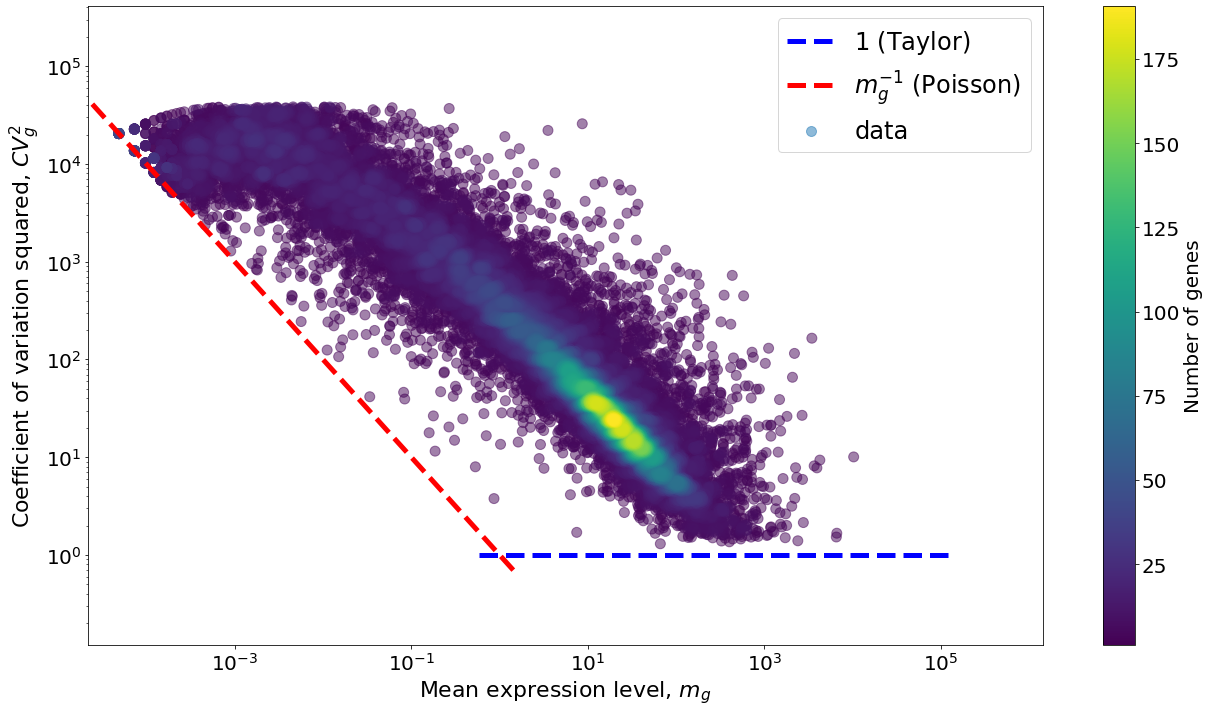

In [87]:
fig, ax = plt.subplots(figsize=(18,10))
ax.set_xlim(1e-3, 5e2)

plotcv2mean(means.values, var.values, ax=ax, normalisation_str='counts', alpha=0.5, colorbar=True)
#ax.set_xlim(1e-4,5e1)
#fig.colorbar(cm.ScalarMappable(norm=None, cmap='Blues'))
plt.show()
fig.savefig(f"cv2_mean_dense_{data_source}.pdf")

# $\sigma^2$ vs $<>$

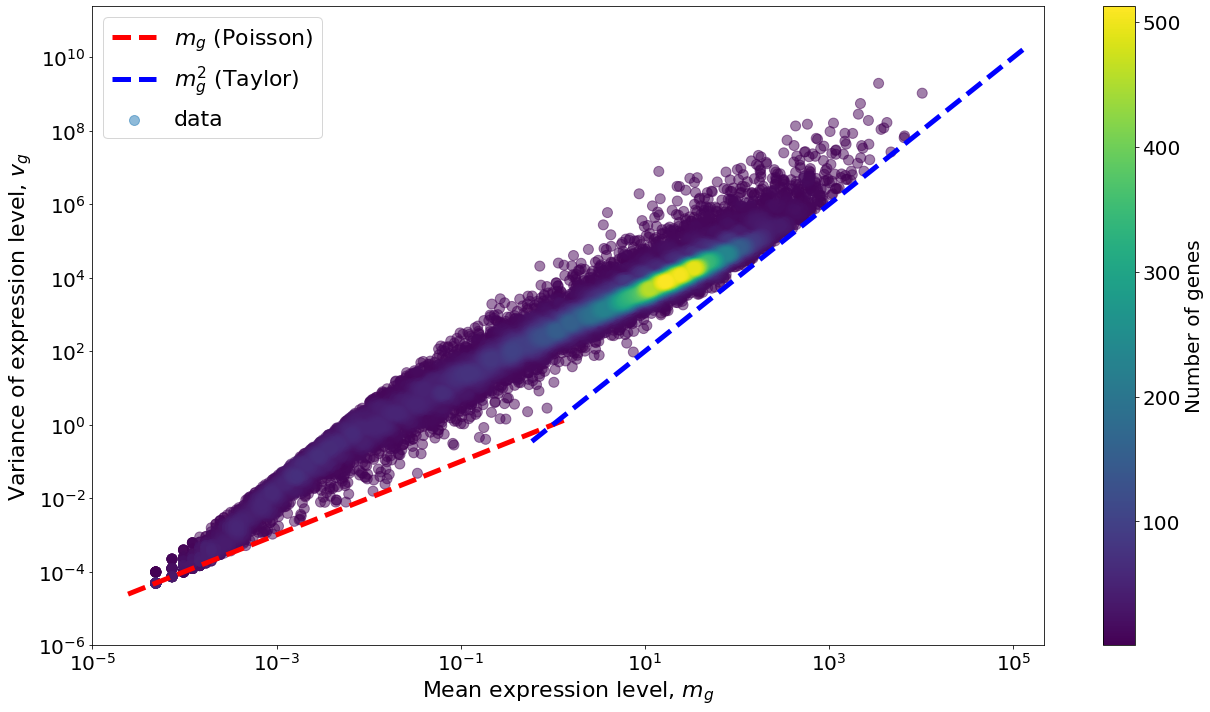

In [86]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(18,10))

#plt.scatter(means, var, c='gray', alpha=0.3, s=80, label='genes')
plotvarmen(means.values, var.values, ax=ax, alpha=0.5, colorbar=True)

ax.set_ylim(1e-6,np.power(10,np.log10(var.max())+1))
ax.set_xlim(1e-5,max(means)*1.5)
ax.legend(fontsize=22)
plt.show()
fig.savefig(f"var_mean_dense_{data_source}.pdf")

# Mean vs Occurrence

In [ ]:
fig=plt.figure(figsize=(10,8))
nfiles = len(data["M"])
plt.scatter(O*nfiles, means, c='b', alpha=0.8, label='genes')
#plt.scatter(O_null*len(M_null), means_null*5, c='orange', alpha=0.8, label='genes')

x = np.linspace(1,nfiles)
plt.plot(x, x/(nfiles), lw=4, label='bound', c='cyan', ls='--')


bin_means, bin_edges, _ = stats.binned_statistic(O*nfiles, means, statistic='mean', bins=np.logspace(-3,6))
x = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(x,bin_means, marker='x', c='r', label='binned average')
plt.ylabel("$<counts>$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(counts)$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(means[means!=0].min()/5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+8000)
plt.legend(fontsize=20)
plt.show()
fig.savefig("mean_occ.pdf")

In [ ]:
from scipy.optimize import curve_fit

fig=plt.figure(figsize=(12,8))
nfiles = len(data["M"])
means_nozero = means_nozero.dropna()
x_data = O.reindex_like(means_nozero)*nfiles

plt.scatter(x_data, means_nozero, c='b', alpha=0.8, label='genes')

bin_means, bin_edges, _ = stats.binned_statistic(x_data, means_nozero, statistic='mean', bins=np.logspace(0,5,30))
x = (bin_edges[1:]+bin_edges[:-1])/2.
plt.scatter(x,bin_means, marker='x', c='r', label='binned average')

bin_mins, _, _ = stats.binned_statistic(x_data, means_nozero, statistic='min', bins=np.logspace(0,5,30))
#f = lambda x, a, b, c, d:np.exp(-a*x) + b*x + c + d*x*x
#f = lambda x, a, C: C + np.power(a, -x)

#popt, pcov = curve_fit(f, x[2:], bin_mins[2:] )
#plt.scatter(x,bin_mins, marker='x', c='g', label='bound')
#plt.plot(x,f(x, *popt), c='g', label='bound')


plt.ylabel("$<counts(>0)>$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(counts)$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+10000)
plt.legend(fontsize=20)
plt.show()
fig.savefig("mean_occ_non_zero.pdf")

# M vs N_zeros

In [ ]:
from scipy.optimize import curve_fit

x_data = M
y_data = cell_zeros/len(A)

plt.scatter(x_data, y_data, label='cell')
bin_means, bin_edges, _ = stats.binned_statistic(x_data, y_data, statistic='mean', bins=np.linspace(0,8000,10))
x = ((bin_edges[1:]+bin_edges[:-1])/2.)[~np.isnan(bin_means)]
bin_means = bin_means[~np.isnan(bin_means)]
plt.scatter(x,bin_means, marker='x', c='r', label='binned average')

fit_func = lambda x, a, C: C + a*x


popt, pcov = curve_fit(fit_func, x, bin_means )
plt.plot(x,fit_func(x, *popt), c='g', ls='--', label='fit (%.10f x + %.3f)'%(popt[0], popt[1]))

plt.xlabel("M")
plt.ylabel("#zeri/#geni")

plt.legend()
plt.show()

In [ ]:
from scipy.optimize import curve_fit

x_data = M
y_data = np.log10(cell_zeros/len(A))

plt.scatter(x_data, y_data, label='cell')
bin_means, bin_edges, _ = stats.binned_statistic(x_data, y_data, statistic='mean', bins=np.linspace(0,4000,10))
x = ((bin_edges[1:]+bin_edges[:-1])/2.)[~np.isnan(bin_means)]
bin_means = bin_means[~np.isnan(bin_means)]
plt.scatter(x,bin_means, marker='x', c='r', label='binned average')

fit_func = lambda x, a, C: C + a*x


popt, pcov = curve_fit(fit_func, x, bin_means )
plt.plot(x,fit_func(x, *popt), c='g', ls='--', label='fit (%.5f x + %.3f)'%(popt[0], popt[1]))

plt.xlabel("M")
plt.ylabel("log(#zeri/#geni)|M")
plt.xlim(0,8000)

plt.legend()
plt.show()

In [ ]:
from scipy.optimize import curve_fit

x_data = M
y_data =cell_zeros/len(A)

plt.scatter(x_data, np.log2(y_data), label='cell')
bin_means, bin_edges, _ = stats.binned_statistic(x_data, y_data, statistic='mean', bins=np.linspace(0,4000,10))
x = ((bin_edges[1:]+bin_edges[:-1])/2.)[~np.isnan(bin_means)]
bin_means = bin_means[~np.isnan(bin_means)]
plt.scatter(x,np.log2(bin_means), marker='x', c='r', label='binned average')

fit_func = lambda x, a, C: C + a*x


popt, pcov = curve_fit(fit_func, x, bin_means )
plt.plot(x,np.log2(fit_func(x, *popt)), c='g', ls='--', label='fit (%.5f x + %.3f)'%(popt[0], popt[1]))

plt.xlabel("M")
plt.ylabel("log(#zeri/#geni|M)")

plt.xlim(0,8000)

plt.legend()
plt.show()

# P(0|M)

In [88]:
def p0m(df, M, limits = (100,110)):
    M_sorted = M.sort_values(ascending=True)
    quantiles = np.quantile(M, q=np.linspace(0,1,10)[:-1])
    #quantiles = np.linspace(M.min(), M.max(), 20)
    M_classes = pd.Series(index=M.index, data=np.digitize(M, quantiles))
    f = df.mean(1)
    f = f/f.sum()
    f_ = df.apply(lambda x: x[x>0].mean(), 1)
    f_ = f_/f_.sum()
    ret = {}
    for g in f.sort_values(ascending=False).index[limits[0]:limits[1]]:
        genexpr = df.loc[g,:]
        ret[g] =  [(genexpr[M_classes[M_classes==c].index]==0).astype(int).sum()/len(M_classes[M_classes==c]) for c in np.arange(len(quantiles))+1]
        del genexpr
        gc.collect()
    return ret, quantiles, (f.sort_values(ascending=False)[limits[0]:limits[1]].mean(), f_.sort_values(ascending=False)[limits[0]:limits[1]].mean())

In [90]:
import importlib, seaborn
importlib.reload(seaborn)
import seaborn as sns

In [92]:
from scipy.optimize import curve_fit
fig = plt.figure(figsize=(20,10))
palette = itertools.cycle(sns.color_palette(palette="Set1", n_colors=100, desat=.9))

def markers():
    for m in ['x', 'o', '.', ',', 'v', '>', '<', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
        yield m

subdf = pd.read_csv("tm/mainTable_Bladder.csv", index_col=0)
M = subdf.sum(0)
results = pd.DataFrame(columns=["rank", "a", "b", "f", "f_"])
for under_limit in np.linspace(1, 2e4, num=5, dtype=int):
    print(under_limit)
    color = next(palette)
    markers_cycle = markers()
    p0mdata, M_bins, F = p0m(subdf, M, limits=(under_limit,under_limit+5))
    tmp = []
    for g in p0mdata.keys():
        tmp.append(p0mdata[g])
        plt.plot(M_bins, p0mdata[g], label=g, c=color, marker = next(markers_cycle))
    tmp=np.average(tmp, 0)
    try:
        popt, pcov = curve_fit(lambda x, a, b: a - b*x, M_bins, tmp)
        results = results.append(pd.Series(name=under_limit, data=[under_limit, popt[0], popt[1], F[0], F[1]], index=["rank", "a", "b", "f", "f_"]))
    except:
        print(*sys.exc_info())
del subdf
del M
plt.yscale('log')

plt.xlabel("M", fontsize=24)
plt.ylabel("P(0|M)")

plt.ylim(5e-4,1)

#plt.legend(ncol=3)
fig.savefig("logpm.pdf")
fig.savefig("logpm.png")

FileNotFoundError: [Errno 2] File tm/mainTable_Bladder.csv does not exist: 'tm/mainTable_Bladder.csv'

<Figure size 1440x720 with 0 Axes>

In [ ]:
subdf = pd.read_csv("mainTable_Bladder.csv", index_col=0)
M = subdf.sum(0)
M_sorted = M.sort_values(ascending=True)
quantiles = np.quantile(M, q=np.linspace(0,1,10)[:-1])
#quantiles = np.linspace(M.min(), M.max(), 20)
M_classes = pd.Series(index=M.index, data=np.digitize(M, quantiles))

def extrapolate_b(genexpr):
    tmp = [(genexpr[M_classes[M_classes==c].index]==0).astype(int).sum()/len(M_classes[M_classes==c]) for c in np.arange(len(quantiles))+1]
    popt, pcov = curve_fit(lambda x, a, b: a - b*x, quantiles, tmp)
    del tmp
    return popt[1]
bs = subdf.apply(extrapolate_b, 1)
fs = subdf.mean(1)

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()



ax.scatter(fs,bs, c="gray", alpha=0.5, ls='--')

ax.set_xlim(fs.min()*0.8, results["f"].max()*1.5)
ax.set_ylim(bs.min()*0.8, results["b"].max()*1.5)

ax.set_xlabel("f", fontsize=22)
ax.set_ylabel("b", fontsize=22)

ax.set_xlim(1e-4, fs.max())

ax.xaxis.set_major_formatter(FormatStrFormatter('%.0E'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0E'))

ax.set_xscale('log')
#ax.set_yscale('log')


plt.show()

fig.savefig("p0m_allgenes.pdf")

In [ ]:
results

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()



ax.scatter(results["f"], results["b"], c="gray", alpha=0.5, ls='--')

ax.plot(results["f"], results["f"], ls='--')


ax.set_xlim(results["f"].min()*0.8, results["f"].max()*1.5)
ax.set_ylim(results["b"].min()*0.8, results["b"].max()*1.5)

ax.set_xlabel("f", fontsize=22)
ax.set_ylabel("b", fontsize=22)

ax.set_xlim(1e-5, results["f"][1:].max())

ax.xaxis.set_major_formatter(FormatStrFormatter('%.0E'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0E'))

ax.set_xscale('log')

plt.show()
fig.savefig("p0m_fbrelationship.pdf")

# Null model 1

In [ ]:
tissue = "Bone-Marrow_c-kit"

try:
    data = load_tissue(tissue, "null_1")

    means_null_1 = data['means']
    var_null_1 = data['var']
    f_null_1 = data['freq']
    O_null_1 = data['O']
    M_null_1 = data["M"]
    cv2_null_1 = data['cv2']
    diffWords_null_1 = data['diffWords']
    means_nozero_null_1 = data['means_nonzero']
except:
    print(*sys.exc_info())

try:
    data = load_tissue(tissue, "mazzolini")

    means_null = data['means']
    var_null = data['var']
    f_null = data['freq']
    O_null = data['O']
    M_null = data["M"]
    cv2_null = data['cv2']
    diffWords_null = data['diffWords']
    means_nozero_null = data['means_nonzero']
except:
    print(*sys.exc_info())
    
data = load_tissue(tissue, "data")

means = data['means']
var = data['var']
f = data['freq']
O = data['O']
M = data["M"]
cv2 = data['cv2']
diffWords = data['diffWords']
means_nozero = data['means_nonzero']
#mazzolini(M, f, tissue)

In [ ]:
fig = plt.figure(figsize=(15,8))
x = np.arange(1, len(f))
plt.ylabel("$Frequency, f_i$", fontsize=24)
plt.xlabel("$RANK, i$", fontsize=24)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-7,1)
plt.plot(x, 1./x, 'g--', lw=2, label='$i^{-1}$')
plt.plot(np.sort(f.reindex_like(f_null_1).dropna())[::-1], c='blue', lw=8, label='Genes')
plt.plot(np.sort(f_null.reindex_like(f_null_1).dropna())[::-1], c='orange', ls='--', lw=6, label='null_model')
plt.plot(np.sort(f_null_1/f_null_1.sum())[::-1], c='green', ls=':', lw=5, label='null_model_1')
plt.legend(fontsize=24)
plt.show()
fig.savefig("zipf_null_0.pdf")
fig.savefig("zipf_null_0.png")

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.scatter(M, diffWords, label='samples')
plt.scatter(M_null, diffWords_null, label='null_model')
plt.xlabel("Realization size", fontsize=22)
plt.ylabel("#different words", fontsize=22)
#bin_means, bin_edges, binnumber = stats.binned_statistic(M, diffWords,statistic='mean', bins=np.linspace(0,max(M)))
#plt.hlines(bin_means[:-15], bin_edges[:-1][:-15], bin_edges[1:][:-15], colors='r', lw=5, label='binned average')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,max(M)*1.1)
plt.legend(fontsize=20)
plt.show()
fig.savefig("heaps_null_o.pdf")
fig.savefig("heaps_null_o.png")

In [ ]:
fig, ax =plt.subplots(figsize=(15,8))
ax.scatter(means_null.reindex_like(means.drop_duplicates()), cv2_null.reindex_like(means.drop_duplicates()), c='orange', label='mazzolini')
ax.scatter(means_null_1.reindex_like(means.drop_duplicates()), cv2_null_1.reindex_like(means.drop_duplicates()), c='green', label='null model 0')
plotcv2mean(means.values, var.values, ax=ax, normalisation_str='counts')
fig.savefig("cvmean_loglog.pdf")

In [ ]:
bins = 10
rang = (0-0.5/bins, 1+0.5/bins)
fig, ax =plt.subplots(1,2, figsize=(20,10))
ax[0].hist(np.array(O.dropna(), dtype=float), histtype='step', lw=5, range = rang, color='blue', density=True, bins=bins, label='data')
if "O_null" in vars().keys():
    ax[0].hist(np.array(O_null, dtype=float), histtype='step', lw=5, range = rang, bins=bins, color='orange', ls='--', density=True, label='Mazzolini')
    
if "O_null_1" in vars().keys():
    ax[0].hist(np.array(O_null_1, dtype=float), histtype='step', lw=5, range = rang, bins=bins, color='green', ls='--', density=True, label='null_1')
ax[0].set_xlabel("$o_i$", fontsize=24)
ax[0].set_ylabel("pdf", fontsize=24)
ax[0].legend(fontsize=20)

ax[1].hist(np.array(O.dropna(), dtype=float), histtype='step', lw=5, range = rang, color='blue', density=True, bins=bins, label='data')
if "O_null" in vars().keys():
    ax[1].hist(np.array(O_null, dtype=float), histtype='step', lw=5, range = rang, bins=bins, color='orange', ls='--', density=True, label='Mazzolini')
    
if "O_null_1" in vars().keys():
    ax[1].hist(np.array(O_null_1, dtype=float), histtype='step', lw=5, range = rang, bins=bins, color='green', ls='--', density=True, label='null_1')
ax[1].set_xlabel("$o_i$", fontsize=24)
ax[1].set_ylabel("pdf", fontsize=24)
ax[1].legend(fontsize=20)

ax[1].set_yscale('log')
ax[1].set_xscale('log')

plt.show()
fig.savefig("U_null_0.pdf")
fig.savefig("U_null_0.png")

# Development stage

In [ ]:
tissue ="Liver"

spec_files = [f for f in files if tissue in f]

print(spec_files)
data = pd.read_csv(f"data/{spec_files[1]}", sep=" ")
data = data[data.columns[data.columns.isin(df_info['Cell_id'])]]

saved = []
frac_of = {}

#tissues = df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']=='Adult')]['tissue'].unique() # only adults
phases = df_info[df_info['Cell_id'].isin(data.columns)]['Development_stage'].unique()

print(phases)
for phase in phases:
    df = data.reindex(columns=df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']==phase)]['Cell_id'])
    #df = df.divide(df.sum(0), 1).applymap(lambda cpm: np.log(cpm*1e6+1)) #log(cpm +1)
    A = df.sum(axis=1)
    M = df.apply(np.sum, 0)
    gene_presence_nonnull = df.apply(lambda x: len(x[~x.isna() & (x>0)]), 1).astype(int)
    frac_of[phase] = {'data': A,
                      'N': len(M)}
    
    diffWords = df.apply(lambda x: len(x[x>0]), 0)
    
    save_model(df, phase, tissue)
    mazzolini(M, A/A.sum(), tissue)
    null_model(df, M, A/gene_presence_nonnull)
    heaps(M, diffWords, tissue)
    
    saved.append(tissue)
    df.to_csv(f"mainTable_{tissue}_{phase}.csv", index=True, header=True)

In [ ]:
fig,ax = plt.subplots()

ax.plot(load_tissue("Liver","Fetal")["freq"].sort_values(ascending=False).values, label="Fetal")
ax.plot(load_tissue("Liver","Adult")["freq"].sort_values(ascending=False).values, label="Adult")

ax.set_xscale("log")
ax.set_yscale("log")

plt.show()

In [ ]:
fig,ax = plt.subplots()

ax.scatter(load_tissue("Liver","Fetal")["M"], load_tissue("Liver","Fetal")["diffWords"], label="Fetal")
ax.scatter(load_tissue("Liver","Adult")["M"], load_tissue("Liver","Adult")["diffWords"], label="Adult")

plt.show()